# Imports

In [1]:
import pandas as pd
import psycopg2

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

# Read Data Set

In [2]:
df = pd.read_csv("mergeData_v4.csv")
df.head()

,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,total_time,distancePed,max_speed,PKE,PKE_Steering,speed_react,reaction_time,hadCollision
0,5.919151,0.503649,0.965743,0.820576,0.030731,13.796202,0.000655,0.014468,0.028719,0.039370,15.405173,89.992450,11.669766,1.932290,-0.000150,7.754880,1.048791,0
1,7.580378,0.499771,0.891302,0.878839,-0.026652,31.451253,0.000345,0.058767,0.010391,0.063480,11.412381,85.063860,13.499710,0.878493,0.000274,13.472353,2.106615,0
2,9.474048,0.494557,0.952182,0.781126,0.006292,53.873833,0.001231,0.022506,0.045416,0.106281,102.356492,789.212800,25.851397,2.857169,0.000108,25.585112,0.079211,1
3,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,0.159198,7.505478,88.011610,20.055070,2.969647,-0.000258,19.412087,1.161592,0
4,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,0.000430,0.102442,0.079023,0.158822,8.681609,105.973686,19.697004,4.033468,0.000066,18.461056,1.275896,0


### Distribution

In [3]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  54 (9.66%)
Number of False cases: 505 (90.34%)


## Split data set

In [5]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np

data = df.copy()
X = data.drop('hadCollision', axis=1) 
y = data['hadCollision']

random_state = np.random.RandomState(0)

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(X[y < 2], y[y < 2],
                                                    test_size=.5,
                                                    random_state=random_state)

# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

In [6]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.43


### Plot the Precision-Recall curve

Text(0.5,1,'2-class Precision-Recall curve: AP=0.43')

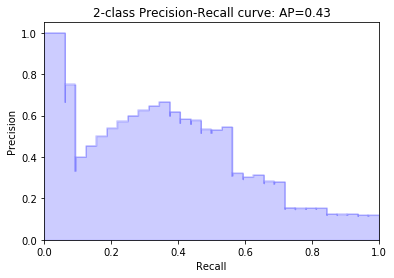

In [7]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## One vs Rest

In [27]:
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5,
                                                    random_state=random_state)

# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier

# Run classifier
classifier = OneVsRestClassifier(svm.LinearSVC(random_state=random_state))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))


In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.84


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


### Plot the micro-averaged Precision-Recall curve

Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.84')

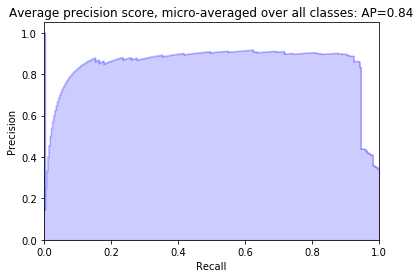

In [29]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))